<h1 style="color:#AD33FF;font-size:25px;">
    Loan Approval Prediction Model Building : 
    <strong style="color:#653DFF;font-size:27px;">
        V1
    </strong>
</h1>
<p style="color:#E6F9D3;font-size:15px;">
    This section will show a way of data processing and training different ML Model and get best accuracy.
<\p>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv


In [2]:
import os,sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

## Data Loading

In [4]:
train_path = "/kaggle/input/playground-series-s4e10/train.csv"
test_path = "/kaggle/input/playground-series-s4e10/test.csv"
sample_sub_path = "/kaggle/input/playground-series-s4e10/sample_submission.csv"
train_ds = pd.read_csv(train_path,index_col='id')
train_ds.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [5]:
df_1=train_ds.copy()

## Data Preprocessing

In [6]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [7]:
df_1.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,58645.0,27.550857,6.033216,20.00,23.00,26.00,30.00,123.00
person_income,58645.0,64046.172871,37931.106978,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_amnt,58645.0,9217.556518,5563.807384,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645.0,0.159238,0.091692,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.00,3.00,4.00,8.00,30.00
loan_status,58645.0,0.142382,0.349445,0.00,0.00,0.00,0.00,1.00


**Understanding** : 
1) Outliers : person_age,person_income,person_emp_length, [In their maximum value side]

2) Significent Difference in Feature values suggests *Standarization* or *Normalization* could be good.

3) Invalid entry : loan_percent_income [0 --> Even though he is having income]

In [8]:
df_1.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [9]:
#Drop unnecessary null values
df_1.dropna(inplace=True)

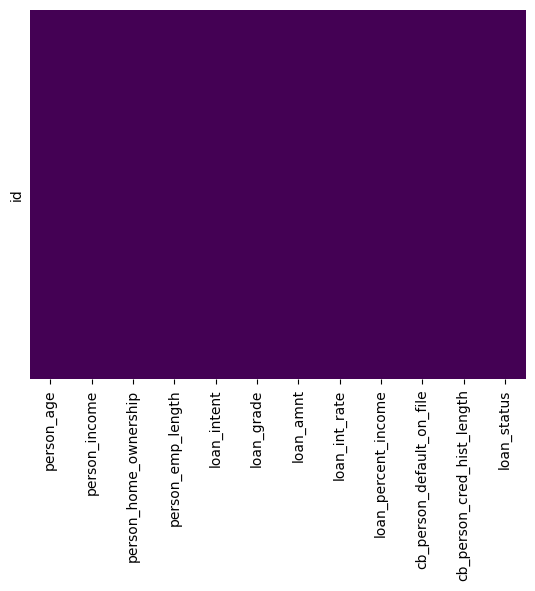

In [10]:
# Plotting the null values
sns.heatmap(df_1.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()
#No null values

In [11]:
#Dropping duplicates
if df_1.duplicated().sum():
    df_1.drop_duplicates(inplace=True)

In [12]:
#Neumerical Columns
num_col = df_1.select_dtypes(exclude='object').columns
#Categorical Columns
cat_col = df_1.select_dtypes(include='object').columns

In [13]:
print(f"Neumerical Columns : {num_col.values.tolist()}\n\n")
print(f"Categorical Columns : {cat_col.values.tolist()}")

Neumerical Columns : ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']


Categorical Columns : ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


## Exploritory Data Analysis (EDA)

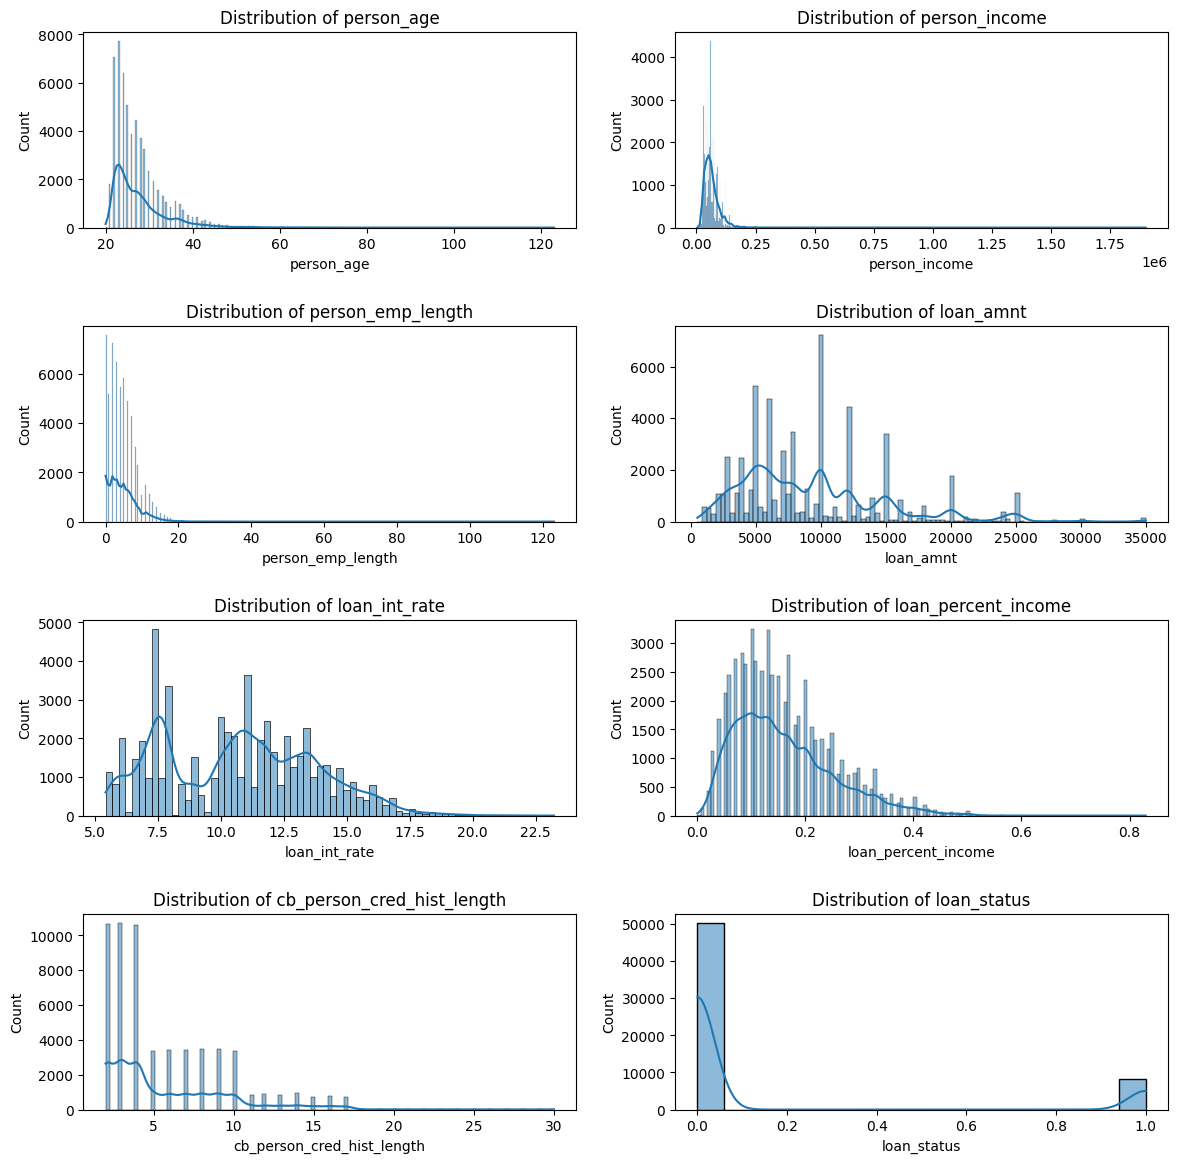

In [14]:
#For neumeric feature
fig,axes = plt.subplots(math.ceil(len(num_col.values)/2),2,figsize=(14,14))
plt.subplots_adjust(hspace=0.5)

#Plot the histogram for all neumeric columns

for idx, col in enumerate(num_col):
    x = idx//2
    y = idx%2
    sns.histplot(df_1[col],kde=True,ax=axes[x,y])
    axes[x, y].set_title(f'Distribution of {col}')
    axes[x, y].set_xlabel(col)
    axes[x, y].set_ylabel('Count')
plt.show()

* person_age, person_emp_length,loan_percent_income and cb_person_cred_hist_length suggests the possibility of distance groups or categories with the data.
* The dataset contains a mix of skewed and symmetrical distributions.
* The loan_status is negetively biased

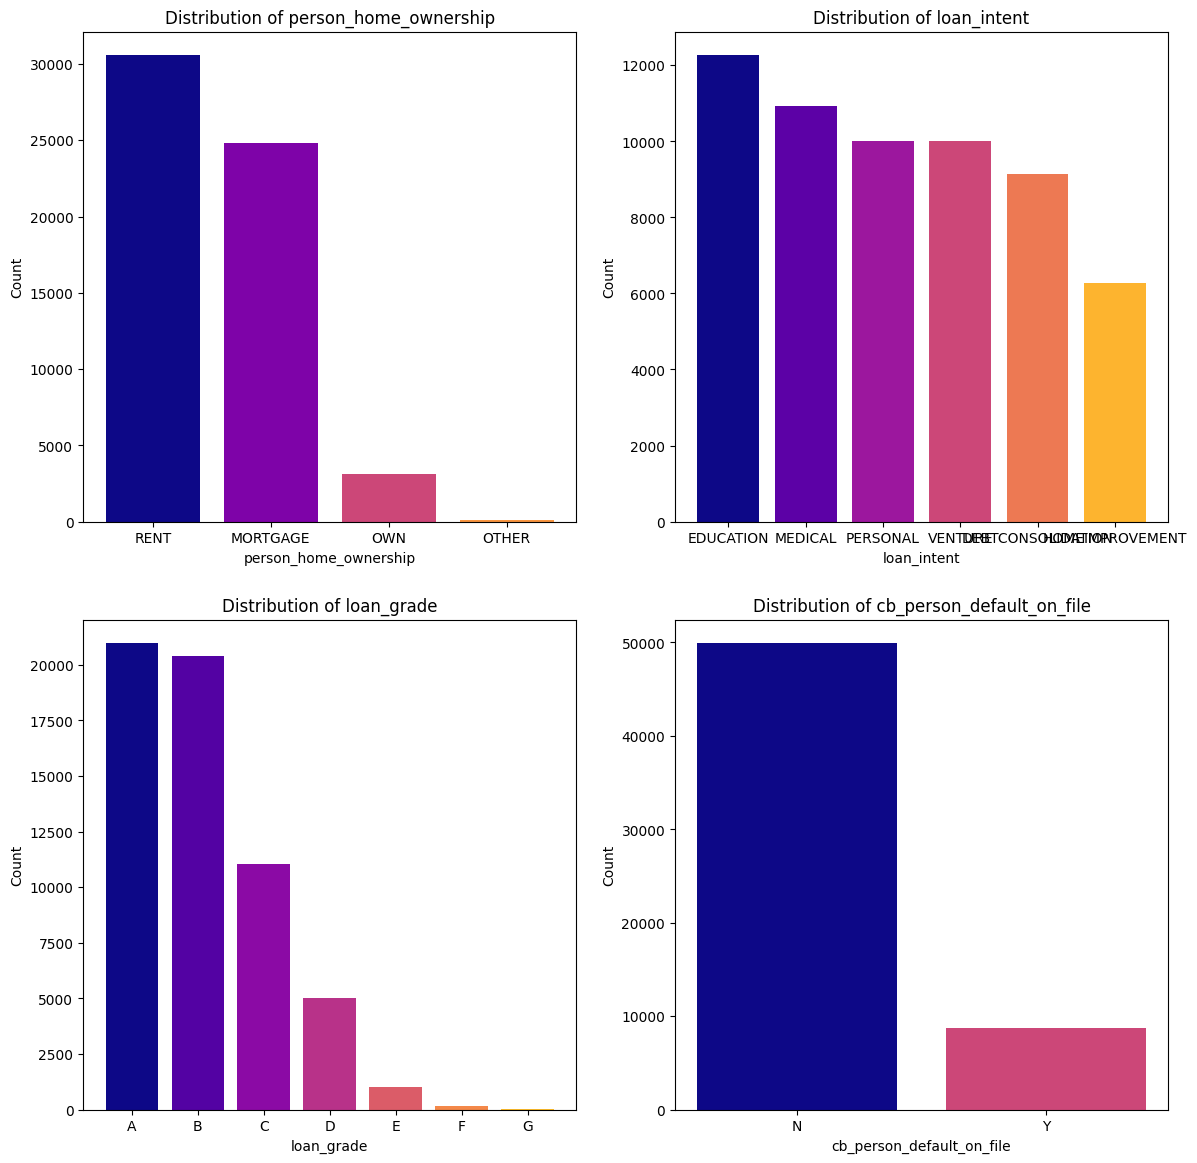

In [15]:
# Categorical
cmap = plt.cm.get_cmap('plasma')
fig,axes = plt.subplots(math.ceil(len(cat_col.values)/2),2,figsize=(14,14))

for idx,col in enumerate(cat_col):
    x = idx//2
    y = idx%2
    value_counts = df_1[col].value_counts()
    ax = axes[x,y]
    ax.bar(value_counts.index,value_counts,color = [cmap(i/len(value_counts.index)) for i in range(len(value_counts.index))])
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

* Main cunsumers are the individuals who are renters or having mortgages.
* Educational and Medical loans are the most common loans
* Most loan applicant are having relatively low credit risk A,B
* The data is n

## Feature Engineering

In [16]:
df_1['person_age'] = df_1['person_age'].clip(upper=60)
df_1['person_emp_length'] = df_1['person_emp_length'].clip(upper=60)

df_1.drop(index=df_1[df_1['person_age'] < df_1['person_emp_length']].index,inplace=True)
df_1 = df_1.reset_index()
df_1.drop('id',inplace=True,axis=1)

In [17]:
df_1.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


* Checking loan_percent_income <br>
loan_percent_income = (loan_amnt / person_income

In [18]:
df_1[(df_1['loan_amnt'] / df_1['person_income']).round(2)!=df_1['loan_percent_income'].round(2)]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
7,21,20000,RENT,0.0,PERSONAL,C,2500,13.49,0.13,Y,3,0
10,30,78000,MORTGAGE,5.0,VENTURE,B,12800,10.59,0.17,N,5,0
15,29,33000,OWN,8.0,MEDICAL,A,7300,8.90,0.23,N,8,0
32,30,80000,RENT,3.0,MEDICAL,B,6000,10.75,0.07,N,8,0
37,22,68000,MORTGAGE,7.0,PERSONAL,C,15900,13.49,0.25,N,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58545,29,82500,RENT,5.0,EDUCATION,A,17000,7.66,0.22,N,5,0
58559,33,36500,MORTGAGE,9.0,HOMEIMPROVEMENT,C,14000,11.03,0.39,N,5,0
58607,40,43000,RENT,18.0,VENTURE,B,14400,11.71,0.34,N,12,1
58617,22,37000,RENT,6.0,EDUCATION,C,7000,13.49,0.18,Y,4,0


In [19]:
df_1['loan_percent_income'] = df_1['loan_amnt'] / df_1['person_income']
df_1.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.171429,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.071429,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.208333,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.171429,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.100000,N,3,0


In [20]:
df_1[df_1['loan_percent_income']==0]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status


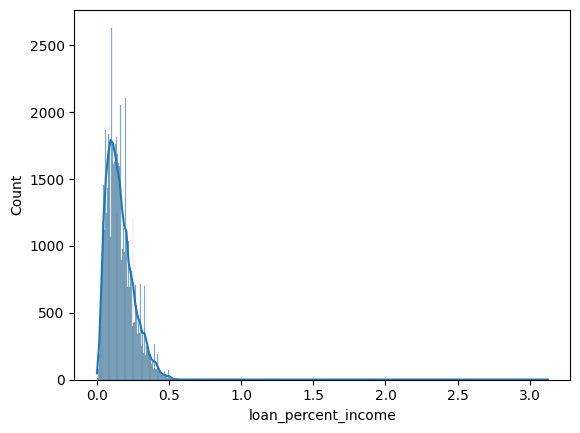

In [21]:
sns.histplot(df_1['loan_percent_income'],kde=True)
plt.show()

In [22]:
df_1.select_dtypes(include=['int','float']).corr()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
person_age,1.000000,0.103358,0.125152,0.051231,0.009514,-0.033031,0.877527,-0.001427
person_income,0.103358,1.000000,0.164919,0.310897,-0.057631,-0.283981,0.082790,-0.169954
person_emp_length,0.125152,0.164919,1.000000,0.091019,-0.104537,-0.066672,0.104910,-0.103057
loan_amnt,0.051231,0.310897,0.091019,1.000000,0.113504,0.641649,0.045754,0.144899
loan_int_rate,0.009514,-0.057631,-0.104537,0.113504,1.000000,0.154557,0.007538,0.338904
loan_percent_income,-0.033031,-0.283981,-0.066672,0.641649,0.154557,1.000000,-0.023394,0.375535
cb_person_cred_hist_length,0.877527,0.082790,0.104910,0.045754,0.007538,-0.023394,1.000000,-0.003039
loan_status,-0.001427,-0.169954,-0.103057,0.144899,0.338904,0.375535,-0.003039,1.000000


In [23]:
df_1.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.171429,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.071429,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.208333,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.171429,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.100000,N,3,0


In [24]:
df_1['loan_grade'].replace({'B':7, 'C':1, 'A':2, 'D':3, 'E':4, 'F':5, 'G':6},inplace=True)
df_1['person_home_ownership'].replace({'RENT':0, 'OWN':1, 'MORTGAGE':2, 'OTHER':3},inplace=True)
df_1['loan_intent'].replace({'EDUCATION':0, 'MEDICAL':1, 'PERSONAL':2, 'VENTURE':3, 'DEBTCONSOLIDATION':4,'HOMEIMPROVEMENT':5},inplace=True)
df_1['cb_person_default_on_file'].replace({'N':0, 'Y':1},inplace=True)


### Correlation between all the rows

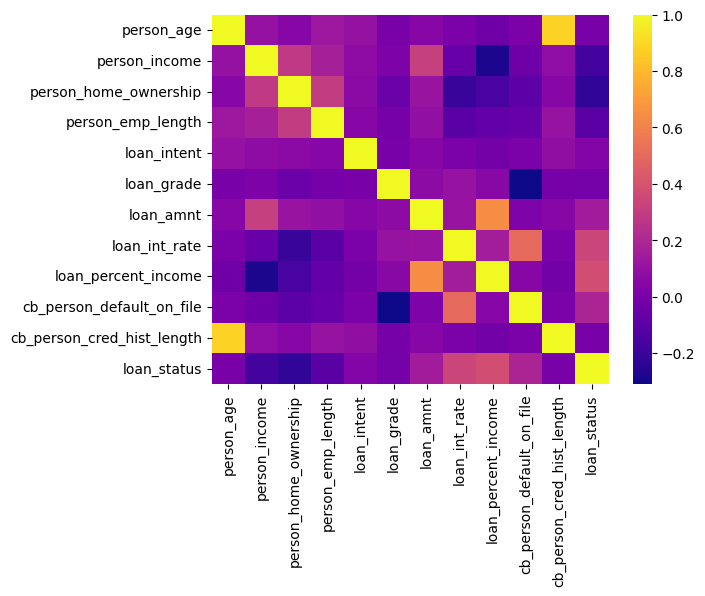

In [25]:
sns.heatmap(df_1.select_dtypes(include=['int','float']).corr(),cmap='plasma')
plt.show()

## Training

### Train Test Split

In [26]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
import catboost as cat
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score

In [27]:
NUM_FOLD = 5

In [28]:
X,Y = df_1.drop(['loan_status'],axis=1),df_1['loan_status']
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.01,random_state=42,stratify=Y)
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()

In [29]:
xgb_params = {
    'enable_categorical': True,
    'random_state': 1,
    'n_estimators': 10000,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'reg_lambda': 0.01,
    'max_depth': 4,
    'max_bin': 5000,
    'subsample': 0.95,
    'reg_alpha': 0.1,
    'tree_method':'gpu_hist',
}
cb_params = {
    'verbose': False,
    'random_state': 1,
    'min_data_in_leaf': 5,
    'n_estimators': 1700,
    'random_strength': 0.79,
    'depth': 7,
    'bagging_temperature': 0.6,
    'l2_leaf_reg': 4,
    'auto_class_weights':'SqrtBalanced',
    'rsm': 0.6,
    
}
params_lgbm = {
    
    'verbose': -1,
    'random_state': 1,
    'objective': 'binary',
    'n_estimators': 4100,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'max_depth': 8,
    'max_bin': 5000,
    'device':'gpu',
    
}
params_rf = {
    
    'random_state': 1,
    'n_estimators': 450,
    'min_samples_leaf': 5,
    'max_leaf_nodes': 960,
    'criterion': 'entropy',
}

In [30]:
def cross_validation(model,label):
    x_original = X.copy()
    y_original = Y.copy()

    val_scores = []
    test_preds_model = []
    oof_model = np.zeros(len(y_original))

    skf = StratifiedKFold(n_splits=NUM_FOLD,shuffle=True,random_state=1)

    for Fold, (train_index,val_index) in enumerate(skf.split(x_original,y_original)):
        X_train,X_val = x_original.iloc[train_index],x_original.iloc[val_index]
        y_train,y_val = y_original.iloc[train_index],y_original.iloc[val_index]

        transformer = sklearn.preprocessing.Normalizer()
        transformer.fit(X_train)
        X_train = transformer.transform(X_train)
        X_val = transformer.transform(X_val)

        model.fit(X_train,y_train)
        y_pred = model.predict_proba(X_val)[:,1]
        roc_auc_score_ = roc_auc_score(y_val,y_pred)
        print(f"Fold {Fold}: roc_auc_score = {roc_auc_score_:.5f}")
        val_scores.append(roc_auc_score_)
    print(f"Mean Validation roc_auc_score of {label}= {np.mean(val_scores)}")
    print(f"STD Validation roc_auc_score of {label} = {np.std(val_scores)}")

# cross_validation(xgbc,'xgb')

In [31]:
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,StackingClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
import xgboost as xgb
import catboost as cat
import lightgbm as lgbm

In [32]:
# xgbc = xgb.XGBClassifier(**xgb_params)
# cross_validation(xgbc,"XGBoost")

In [33]:
# lgbmc= lgbm.LGBMClassifier(**params_lgbm)
# cross_validation(lgbmc,"LGBMClassifier")

In [34]:
# catb = cat.CatBoostClassifier(**cb_params)
# cross_validation(catb,"CatBoostClassifier")

In [35]:
class CustomCatBoostClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self,**kwargs):
        self.model=cat.CatBoostClassifier(**kwargs)

    def convert_toint(self,X):
        X=pd.DataFrame(X)
        float_dtype=X.select_dtypes(include=['float']).columns
        if float_dtype.any():
            X[float_dtype]=(X[float_dtype]*1000).astype('int')
        return X

    def fit(self,X,y):
        X=self.convert_toint(X)
        feature_columns = [c for c in X.columns if c !='loan_status']
        cat_pool=cat.Pool(X,y,cat_features=feature_columns)
        self.model.fit(cat_pool)
        self.classes_=self.model.classes_
        return self

    def predict(self,X):
        X=self.convert_toint(X)
        feature_columns = [c for c in X.columns if c !='loan_status']
        cat_pool_test=cat.Pool(X,cat_features=feature_columns)
        return self.model.predict(cat_pool_test)

    def predict_proba(self,X):
        X=self.convert_toint(X)
        feature_columns = [c for c in X.columns if c !='loan_status']
        cat_pool_test=cat.Pool(X,cat_features=feature_columns)
        return self.model.predict_proba(cat_pool_test)

In [36]:
# Custom_cat=CustomCatBoostClassifier(**cb_params)
# cross_validation(Custom_cat,'Custom_cb')

<h1 style="color:#AD33FF;font-size:25px;">
    Loan Approval Prediction Model Building : 
    <strong style="color:#653DFF;font-size:27px;">
        V2 
    </strong>
</h1>
<p style="color:#E6F9D3;font-size:15px;">
    This section will tell you :
    <ul>
        <li>How to process data.</li>
        <li>How to use Voting Classivier with <strong style="font:bold;">LightGBM</strong> & <strong style="font:bold;">XGBoost</strong></li>
    </ul>
<\p>

<p style="color:#FF9C3D;font-size:15px;">
    Accuracy : 0.9569
</p>

## 1. Module Loading

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import warnings
warnings.filterwarnings('ignore')

In [38]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

## 2. Load Data

In [39]:
for dirname,_,filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname,filename))

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv


In [40]:
train = pd.read_csv(f'/kaggle/input/playground-series-s4e10/train.csv', index_col = 0)
test = pd.read_csv(f'/kaggle/input/playground-series-s4e10/test.csv', index_col = 0)
original=pd.read_csv(f"/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv")
target="loan_status"

data_frame = pd.concat([train,original])

In [41]:
data_frame.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


## 3. Data Exploration and Analysis

In [42]:
data_frame[target].value_counts(normalize=True)

loan_status
0    0.830553
1    0.169447
Name: proportion, dtype: float64

In [43]:
data_frame.isna().mean()

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.009811
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 0.034157
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
loan_status                   0.000000
dtype: float64

In [44]:
data_frame.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

#### 3.1 EDA

In [45]:
df_eda = data_frame.copy()
cat_features = df_eda.loc[:,data_frame.dtypes == 'object'].columns

#For Categorical Feature
df_eda[cat_features] = df_eda[cat_features].apply(lambda x: LabelEncoder().fit_transform(x))

#For Handelling missing value
missed_features = df_eda.loc[:,df_eda.isna().mean() > 0].columns
df_eda[missed_features] = SimpleImputer().fit_transform(df_eda[missed_features])

df_eda.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14,0
1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2,0
2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10,0
3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5,0
4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3,0


### 3.2 Visualize 

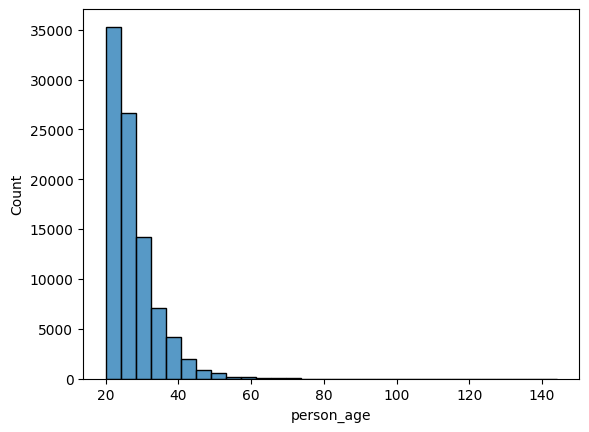

In [46]:
sns.histplot(df_eda['person_age'],kde=False,bins=30)
plt.show()

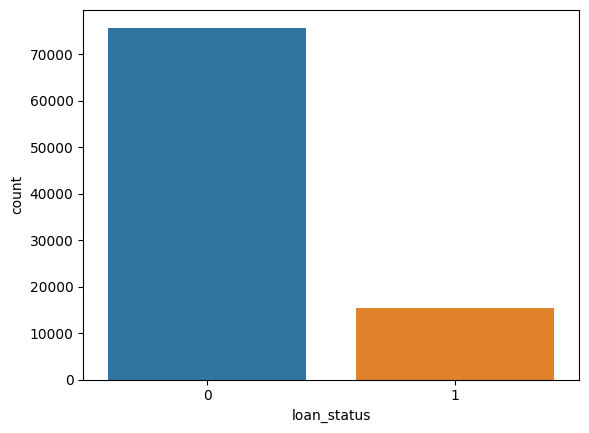

In [47]:
sns.countplot(x='loan_status',data=df_eda)
plt.show()

In [48]:
data_frame['person_home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

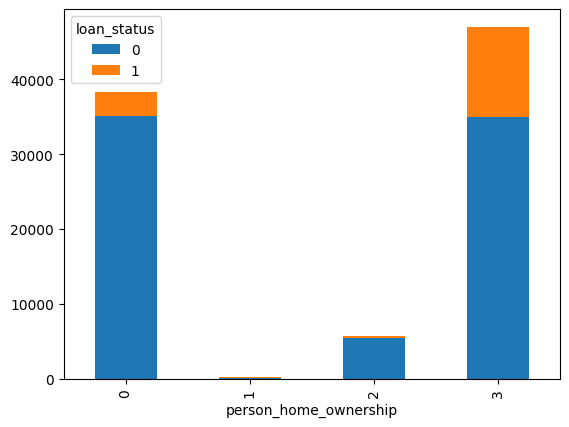

In [49]:
pd.crosstab(df_eda['person_home_ownership'],df_eda['loan_status']).plot(kind='bar',stacked=True)
plt.show()

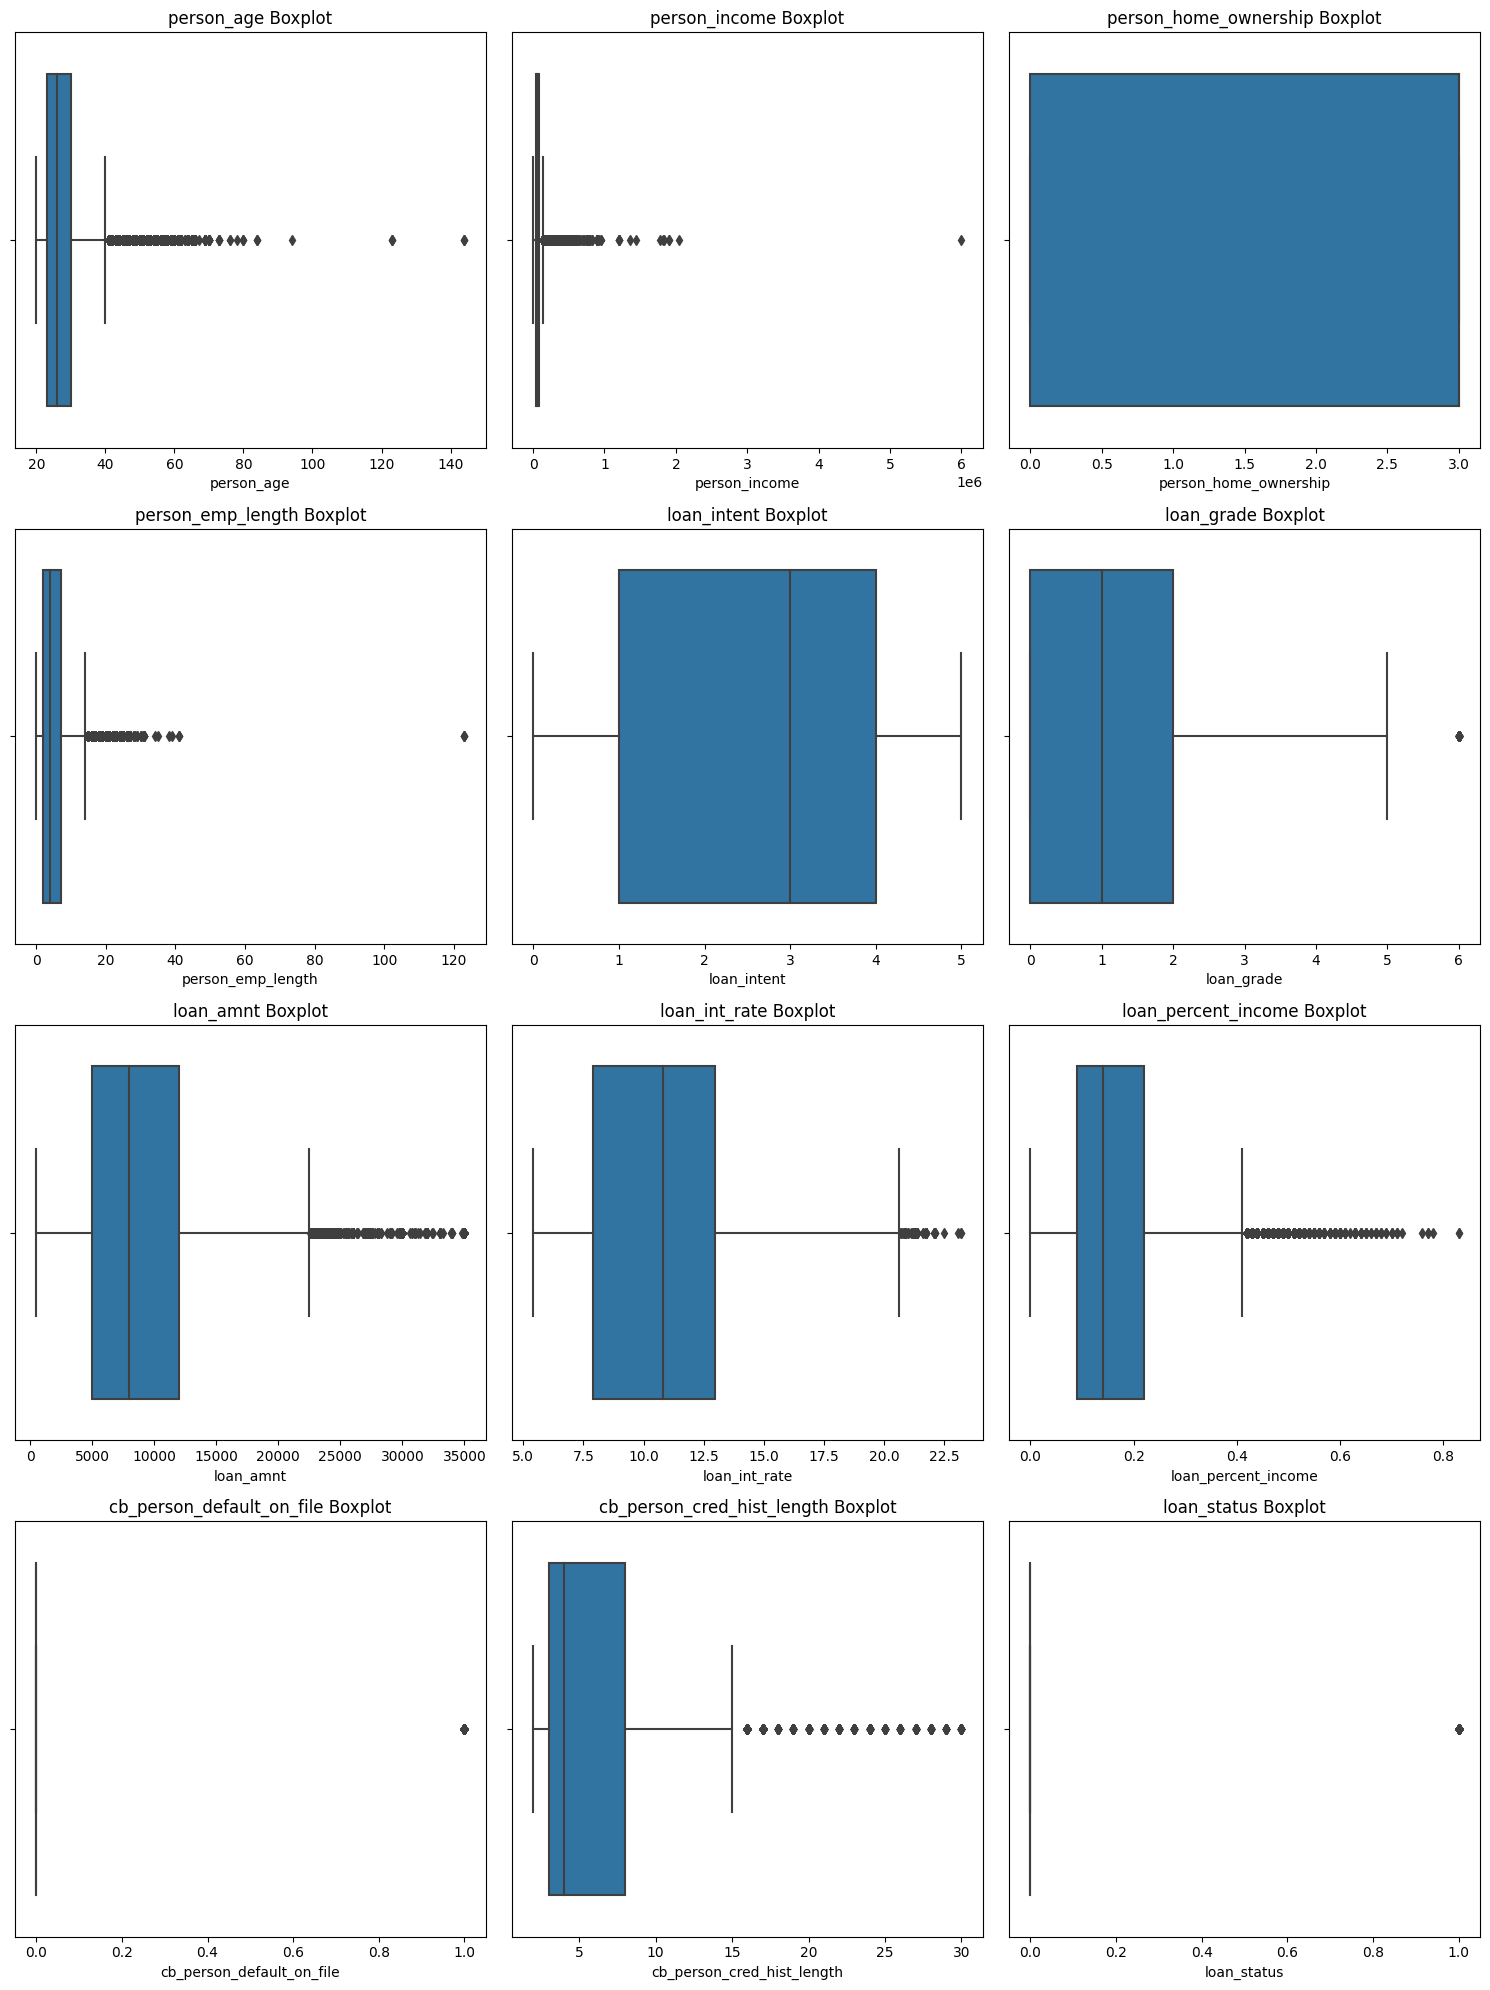

In [50]:
stats_df = pd.DataFrame(index=df_eda.select_dtypes(include=['float64', 'int64']).columns,
                        columns=['Q1', 'Q3', 'IQR'])

num_features = len(df_eda.select_dtypes(include=['float64', 'int64']).columns)
num_cols = 3 
num_rows = math.ceil(num_features / num_cols) 

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
axs = axs.flatten()

for i, column in enumerate(df_eda.select_dtypes(include=['float64', 'int64']).columns):
    Q1 = df_eda[column].quantile(0.25)
    Q3 = df_eda[column].quantile(0.75)
    IQR = Q3 - Q1
    stats_df.loc[column, 'Q1'] = Q1
    stats_df.loc[column, 'Q3'] = Q3
    stats_df.loc[column, 'IQR'] = IQR

    sns.boxplot(x=df_eda[column], ax=axs[i])
    axs[i].set_title(f"{column} Boxplot")

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


## 4. Data Preprocession and Cleaning

In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import numpy as np

In [52]:
class DataCleaner:
    def __init__(self):
        self.ti = {}
        self.ki = KNNImputer()
        
    def fit_label_encoders(self,df):
        cat_features = df.select_dtypes(include=['object']).columns
        for feature in cat_features:
            le = LabelEncoder()
            le.fit(df[feature])
            self.ti[feature] = le
    def transform_labels(self,df):
        for feature,le in self.ti.items():
            df[feature] = df[feature].apply(lambda x : le.transform([x])[0] if x in le.classes_ else -1)
        return df
    def impute_numeric(self,df):
        missed_numeric_feature = df.select_dtypes(include=[float,int]).columns[df.isna().mean() > 0]
        if not missed_numeric_feature.empty:
            df[missed_numeric_feature] = self.ki.fit_transform(df[missed_numeric_feature])
        else:
            print("No numeric columns with missing values to impute.")
        return df
    
    def clean_data(self,df,train):
        if train:
            self.fit_label_encoders(df)
        df = self.transform_labels(df)
        return self.impute_numeric(df)
data_cleaner = DataCleaner()
df = data_cleaner.clean_data(data_frame,train=True)
test = data_cleaner.clean_data(test,train=False)

No numeric columns with missing values to impute.


In [53]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df_eda[column].quantile(0.25)
    Q3 = df_eda[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3.5 * IQR
    upper_bound = Q3 + 3.5 * IQR
    
    if column != target and column != 'cb_person_default_on_file':
        num_outliers_before = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        print(f"Number of outliers in {column} before clipping: {num_outliers_before}")
    
        df = df.loc[lambda x: (x[column] >= lower_bound) & (x[column] <= upper_bound)]
        num_outliers_after = ((df[column]<lower_bound) | (df[column]>upper_bound)).sum()
        print(f"Number of outliers in {column} after clipping : {num_outliers_after}")

Number of outliers in person_age before clipping: 395
Number of outliers in person_age after clipping : 0
Number of outliers in person_income before clipping: 604
Number of outliers in person_income after clipping : 0
Number of outliers in person_home_ownership before clipping: 0
Number of outliers in person_home_ownership after clipping : 0
Number of outliers in person_emp_length before clipping: 67
Number of outliers in person_emp_length after clipping : 0
Number of outliers in loan_intent before clipping: 0
Number of outliers in loan_intent after clipping : 0
Number of outliers in loan_grade before clipping: 0
Number of outliers in loan_grade after clipping : 0
Number of outliers in loan_amnt before clipping: 0
Number of outliers in loan_amnt after clipping : 0
Number of outliers in loan_int_rate before clipping: 0
Number of outliers in loan_int_rate after clipping : 0
Number of outliers in loan_percent_income before clipping: 18
Number of outliers in loan_percent_income after clipp

In [54]:
df.shape

(90015, 12)

In [55]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14,0
1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2,0
2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10,0
3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5,0
4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3,0


In [56]:
def create_features(train,test):
    for df in [train,test]:
        df['income_to_age'] = df['person_income'] / df['person_age']
        df['loan_to_income'] = df['loan_amnt'] / df['person_income']
        df['rate_to_loan'] = df['loan_int_rate'] / df['loan_amnt']
        df['log_income'] = np.log1p(df['person_income'])
        df['high_loan_to_income'] = (df['loan_percent_income'] > 0.5).astype(int)
        df['loan_to_employment'] = df['loan_amnt'] / (df['person_emp_length']+0.01)
        df['is_new_credit_user'] = (df['cb_person_cred_hist_length']<2).astype(int)
        df['rate_to_grade'] = df.groupby('loan_grade')['loan_int_rate'].transform('mean')
        df['high_interest_rate'] = (df['loan_int_rate'] > df['loan_int_rate'].mean()).astype(int)
        df['age_to_credit_history']= df['person_age'] / df['cb_person_cred_hist_length']
        df['normalized_loan_amount'] = df.groupby('loan_intent')['loan_amnt'].transform(lambda x : (x-x.mean())/x.std())
        df['income_to_loan'] = df['person_income'] / df['loan_amnt']
        df['log_loan_amnt'] = np.log1p(df['loan_amnt'])
        df['credit_history_to_age'] = df['cb_person_cred_hist_length'] / df['person_age']
        df['high_loan_amount'] = (df['loan_amnt'] > df['loan_amnt'].quantile(0.75)).astype(int)
        df['age_to_employment'] = df['person_age'] / (df['person_emp_length'] + 1)
        df['rate_to_age'] = df['loan_int_rate'] / df['person_age']
        df['high_risk_flag'] = ((df['loan_percent_income'] > 0.4) &
                                (df['loan_int_rate'] > df['loan_int_rate'].mean()) &
                                (df['cb_person_default_on_file'] == 'Y')).astype(int)
        df['age_sin'] = np.sin(2 * np.pi * df['person_age'] / 100)
        df['age_cos'] = np.cos(2 * np.pi * df['person_age'] / 100)
        df['stability_score'] = (df['person_emp_length'] * df['person_income']) / (df['loan_amnt'] * (df['cb_person_cred_hist_length'] + 1))
    
    return train, test
train1,test1 = create_features(df,test)

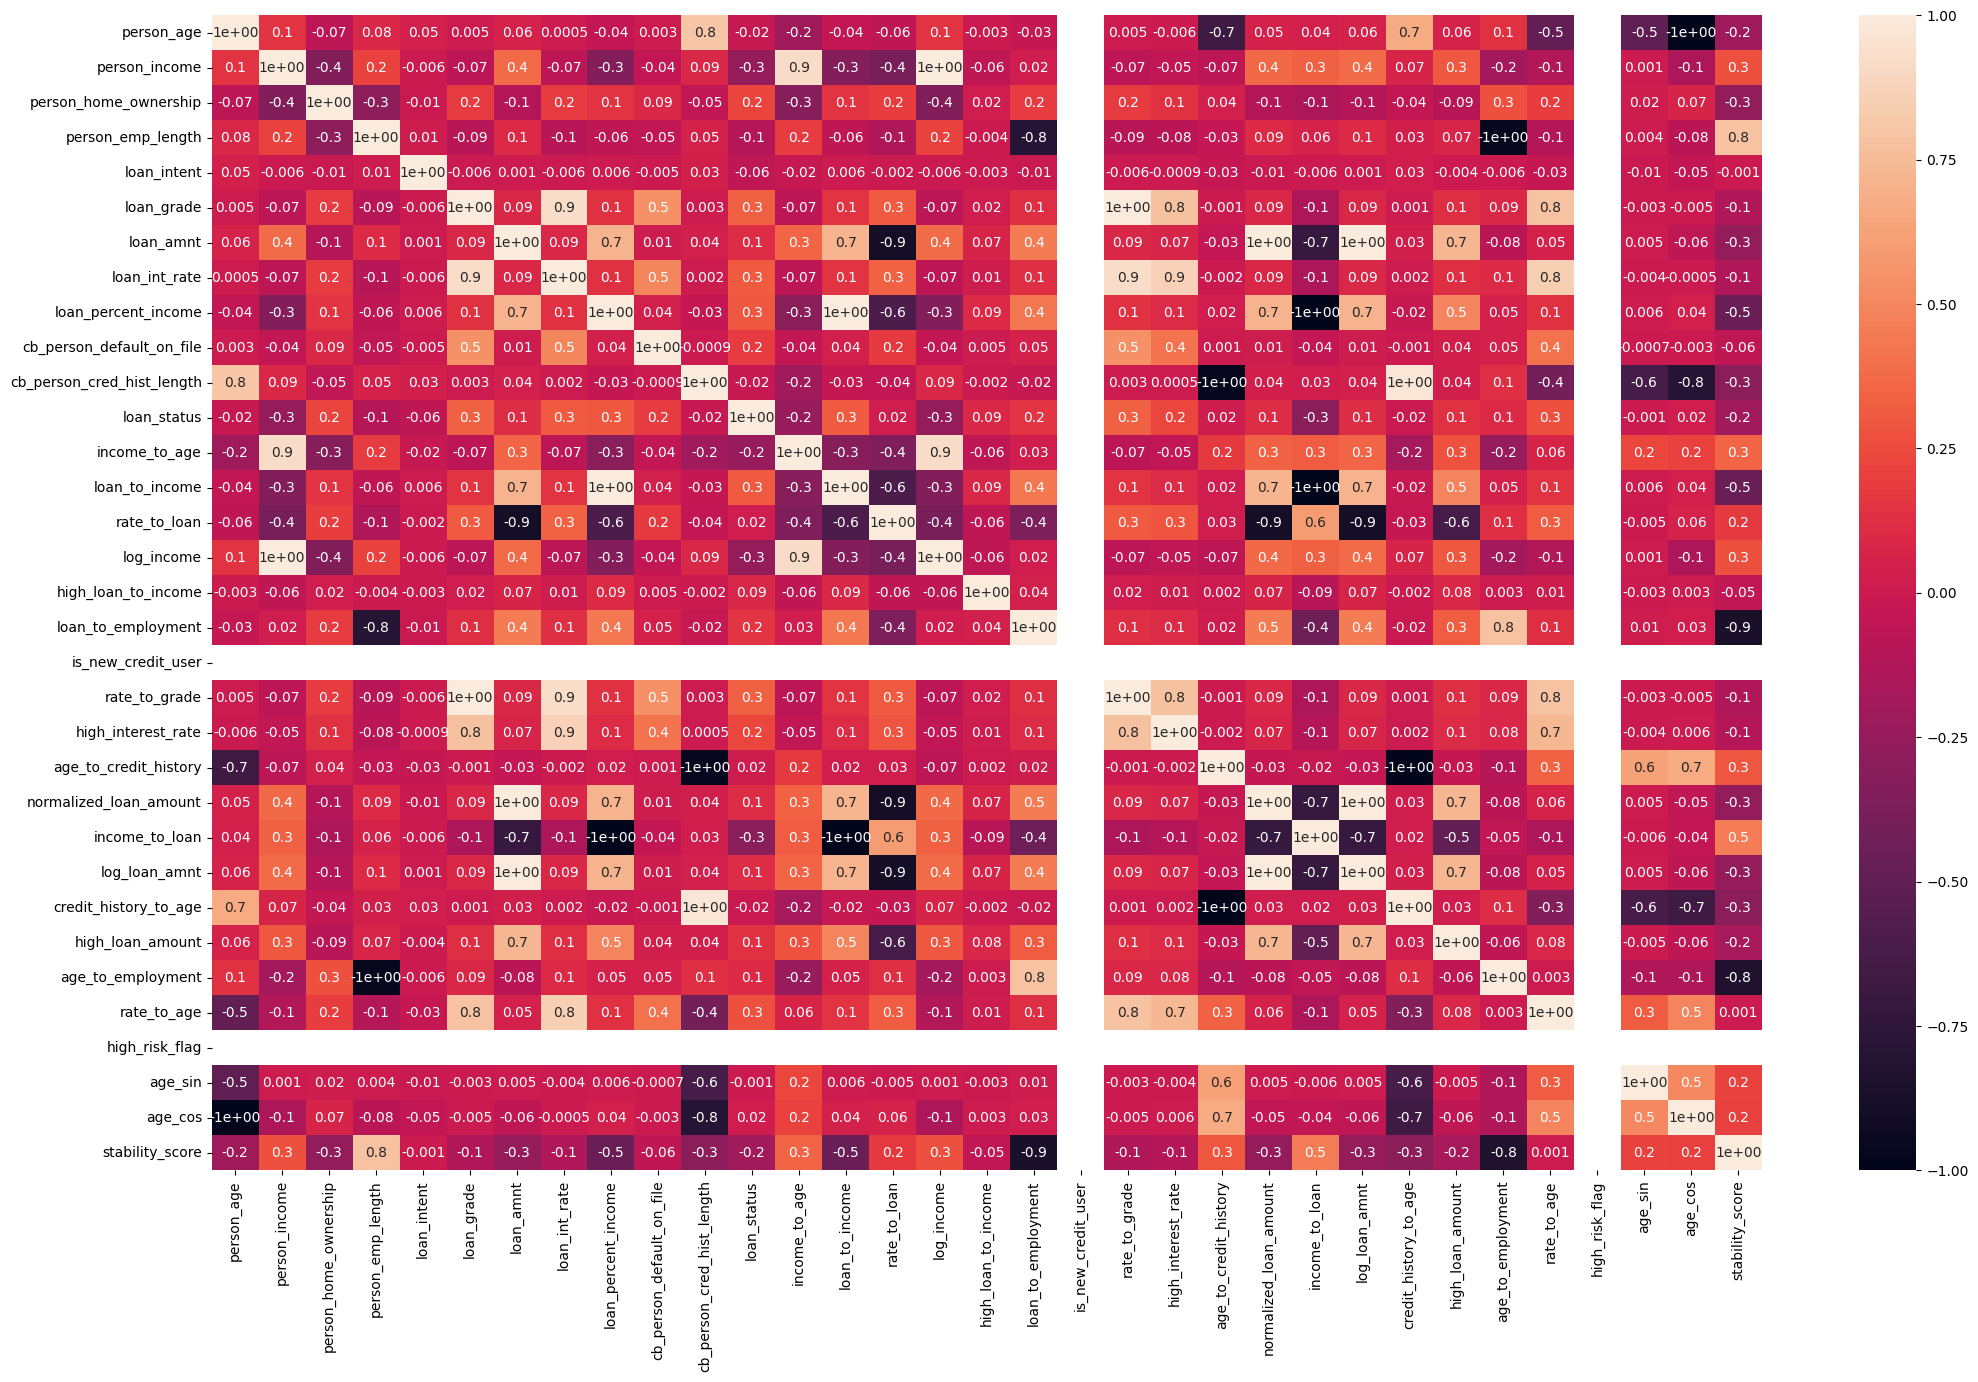

In [57]:
plt.figure(figsize=(25,15))
sns.heatmap(df.corr(method='spearman'),annot=True,fmt='.1')
plt.show()

# Baseline Model Creation

In [58]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [59]:
X = train1.drop(columns=[target])
y= df[target]
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [60]:
models = {
    'LightGBM': LGBMClassifier(device='gpu',n_jobs=-1,verbose=-1),
    'XGBoost' : XGBClassifier(eval_metric='logloss',tree_method='gpu_hist',verbosity=0),
}

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


LightGBM ROC AUC Score : 0.9539


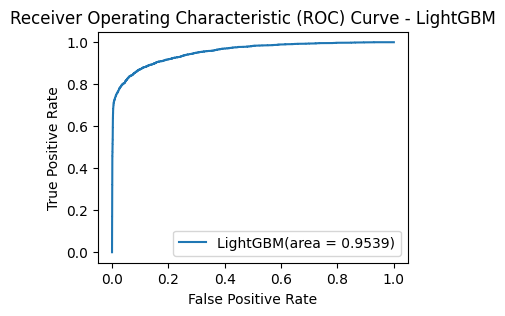

XGBoost ROC AUC Score : 0.9531


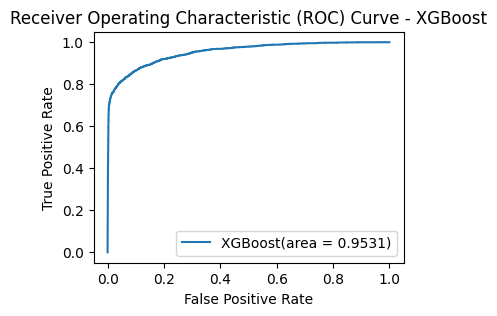

In [61]:
for model_name,model in models.items():
    model.fit(x_train,y_train)
    
    
for model_name,model in models.items():
    y_pred_probs = model.predict_proba(x_test)[:,1]
    roc_auc = roc_auc_score(y_test,y_pred_probs)
    print(f"{model_name} ROC AUC Score : {roc_auc:.4f}")
    
    fpr,tpr,thresholds = roc_curve(y_test,y_pred_probs)
    plt.figure(figsize=(4,3))
    plt.plot(fpr,tpr,label=f"{model_name}(area = {roc_auc:.4f})")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

> CrossValidation

In [62]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

for name,model in models.items():
    stratified_cv = StratifiedKFold(n_splits=5)
    cv_score = cross_val_score(model,x_train,y_train,cv=stratified_cv,scoring='roc_auc')
    
    print(f'-----------{name}')
    print("Cross-validation scores:", cv_score)
    print("Mean cross-validation score:", cv_score.mean())

-----------LightGBM
Cross-validation scores: [0.94520473 0.95690535 0.95682474 0.95654322 0.95762576]
Mean cross-validation score: 0.9546207605880286
-----------XGBoost
Cross-validation scores: [0.94561185 0.95304673 0.95613134 0.9547204  0.95419563]
Mean cross-validation score: 0.9527411901943947


> Ensemble Methods

In [63]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators = [(name,model) for name,model in models.items()],
    voting='soft'
)

stratified_cv = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(voting_clf,x_train,y_train,cv=stratified_cv,scoring='roc_auc')

print(f'-----------Voting Classifier')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

-----------Voting Classifier
Cross-validation scores: [0.94768514 0.95141467 0.95901804 0.95715667 0.95643162 0.96332301
 0.95799553 0.95990909 0.95976337 0.95682825]
Mean cross-validation score: 0.9569525380122034


In [64]:
base_models = {
    "LightGBM": LGBMClassifier(device='gpu', n_jobs=-1, verbose=-1),                      
    "XGBoost": XGBClassifier(eval_metric='logloss', tree_method='gpu_hist', verbosity=0)  
}

models = [("LightGBM", base_models["LightGBM"]), ("XGBoost", base_models["XGBoost"])]

base_weight = 0.25
tuned_weight = 0.50 / len(models)
weights = [base_weight] + [tuned_weight]

voting_clf = VotingClassifier(estimators=models, voting='soft', weights=weights)

stratified_cv = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(voting_clf, X, y, cv=stratified_cv, scoring='roc_auc')
print(f'------------Voting Classifier')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())


------------Voting Classifier
Cross-validation scores: [0.96095562 0.9573033  0.95955358 0.96236958 0.95778033 0.97055629
 0.92908402 0.94256381 0.94646217 0.94754696]
Mean cross-validation score: 0.9534175646577863


# Submission

In [65]:
voting_clf.fit(x_train,y_train)
submission = pd.DataFrame(test.index,columns=['id'])
submission['loan_status'] = voting_clf.predict_proba(test1)[:,1]
submission.to_csv('submission.csv', index=False)

In [66]:
submission.head()

,id,loan_status
0,58645,0.998475
1,58646,0.030623
2,58647,0.415136
3,58648,0.009670
4,58649,0.083681
